In [13]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
def univariate_auc(dataset, variable_name):
    le = LabelEncoder()
    sorted_dataset = dataset[[variable_name, "TYPE"]].sort_values(by=variable_name).dropna()
    fpr, tpr, _ = roc_curve(le.fit_transform(sorted_dataset.TYPE), sorted_dataset[[variable_name]])
    return auc(fpr, tpr)

def balanced_accuracy(dataset, variable_name):
    dataset = pd.concat([dataset[[variable_name]].astype('bool'), dataset[["TYPE"]]], axis=1).sort_values(by=variable_name, ascending=False).dropna()
    tp = dataset[(dataset.TYPE == "Disease") & (dataset[variable_name])].shape[0]
    p = dataset[dataset.TYPE == "Disease"].shape[0]
    tn = dataset[(dataset.TYPE == "Polymorphism") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Polymorphism"].shape[0]
    return (tp/p + tn/n) / 2

In [3]:
RANDOM_STATE = 42

In [4]:
genomic_dataset = pd.read_csv("../data/processed/genomic/dataset.csv.gz", index_col="MUTANT")
genomic_dataset = genomic_dataset[genomic_dataset.TYPE != "Unclassified"]
# genomic_dataset["random"] = np.random.random(size=len(genomic_dataset))

In [5]:
genomic_dataset.shape

(55382, 15)

In [6]:
genomic_dataset.TYPE.value_counts(normalize=True)

Polymorphism    0.67847
Disease         0.32153
Name: TYPE, dtype: float64

In [8]:
genomic_dataset.columns

Index(['TYPE', 'CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY',
       'PHASTCONS46WAY', 'INTRON', 'MISSENSE', 'NEAR-GENE', 'NCRNA',
       'CODING-SYNON', 'UNTRANSLATED', 'NONSENSE', 'SPLICE', 'STOP-LOSS'],
      dtype='object')

In [9]:
# genomic_dataset[["CONS","SNP_DEN", "HAPMAP_SNP_DEN"]].describe().iloc[:8].T.to_csv("/home/marlan/Desktop/describe.csv", index=True, index_label="Variable", float_format="%.2f")
genomic_dataset[["CONS","SNP_DEN", "HAPMAP_SNP_DEN"]].describe().iloc[:8].T

,count,mean,std,min,25%,50%,75%,max
CONS,54326.0,0.652634,0.086864,0.144895,0.587777,0.656068,0.71951,0.897386
SNP_DEN,54326.0,0.064620,0.099475,0.000000,0.029703,0.043860,0.06437,1.042402
HAPMAP_SNP_DEN,54326.0,0.000143,0.000994,0.000000,0.000000,0.000000,0.00000,0.039147


In [7]:
le = LabelEncoder()
X = genomic_dataset[~genomic_dataset.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(genomic_dataset[~genomic_dataset.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [8]:
RANDOM_STATE = 42
cat_vars = ['INTRON','MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
            'NONSENSE', 'SPLICE', 'STOP-LOSS']

cont_vars = genomic_dataset.columns.drop(cat_vars + ["TYPE"], 1).tolist()

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))

scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2,7]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [14]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(genomic_dataset, variable))

CONS : 0.34599381562913867
SNP_DEN : 0.43547667287830555
HAPMAP_SNP_DEN : 0.5161511029725236
PHYLOP46WAY : 0.1743242122974544
PHASTCONS46WAY : 0.2160401792972104


In [19]:
genomic_dataset[genomic_dataset.NONSENSE == 1]

,TYPE,CONS,SNP_DEN,HAPMAP_SNP_DEN,PHYLOP46WAY,PHASTCONS46WAY,INTRON,MISSENSE,NEAR-GENE,NCRNA,CODING-SYNON,UNTRANSLATED,NONSENSE,SPLICE,STOP-LOSS
MUTANT,,,,,,,,,,,,,,,
Q8WWZ4-1322-R-W,Polymorphism,0.480702,0.044332,0.000000,-2.227,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Q86UK0-287-R-G,Polymorphism,0.656038,0.033520,0.000000,3.353,0.995,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
P78363-635-Q-K,Disease,0.727741,0.152542,0.000000,4.245,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-991-G-R,Disease,0.709221,0.121212,0.000000,6.334,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-1022-E-K,Disease,0.762110,0.114286,0.000000,6.301,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-1399-E-K,Disease,0.711572,0.112000,0.000000,5.887,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Q96SE0-371-W-C,Polymorphism,0.607797,0.078167,0.000000,0.297,0.981,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
Q6NUN0-182-E-K,Polymorphism,0.625496,0.051496,0.000000,1.629,0.916,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P68133-358-W-C,Disease,0.443085,0.018957,0.000000,5.418,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(genomic_dataset, variable))

INTRON : 0.4964573696058959
MISSENSE : 0.5060134081250651
NEAR-GENE : 0.4945208118048174
NCRNA : 0.5016971541651165
CODING-SYNON : 0.502288526408369
UNTRANSLATED : 0.5001775150957889
NONSENSE : 0.5037847615825798
SPLICE : 0.5018466823302908
STOP-LOSS : 0.5020965791970466


In [9]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [10]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:  1.1min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f604b691d58>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY', 'PHASTCONS46WAY'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', ve...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [11]:
rf = gs.best_estimator_

In [15]:
features1 = ["PHYLOP46WAY", "PHASTCONS46WAY"] 
features = X.drop(features1, axis=1).columns.tolist() + [features1]


In [16]:
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

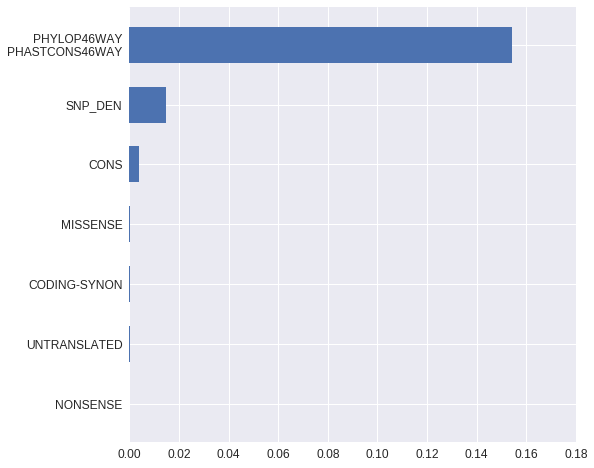

In [27]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=12, scalefig=(2,2), figsize=(8,8), tickstep=1, save="/home/marlan/Desktop/genomic_importance_cluster.pdf")

In [55]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


              precision    recall  f1-score   support

     Disease       0.69      0.64      0.67      5877
Polymorphism       0.83      0.87      0.85     12400

 avg / total       0.79      0.79      0.79     18277



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


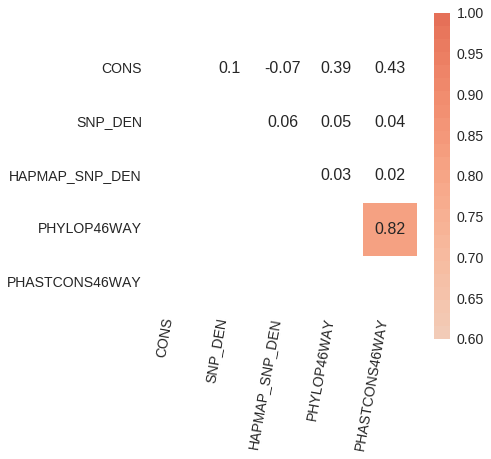

In [25]:
%load_ext autoreload
%autoreload 2
import rfpimp
rfpimp.plot_corr_heatmap(X[cont_vars], figsize=(6,6), label_fontsize=14, 
                         value_fontsize=16, save="/home/marlan/Desktop/genomic_corr.pdf")

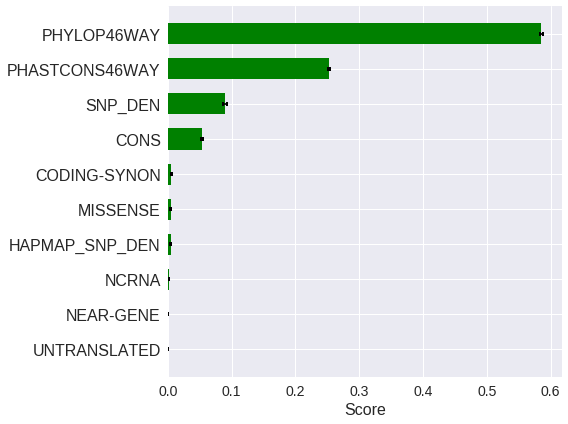

In [11]:
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=14)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_genomic.pdf", bbox_inches='tight', pad_inches=0.1)


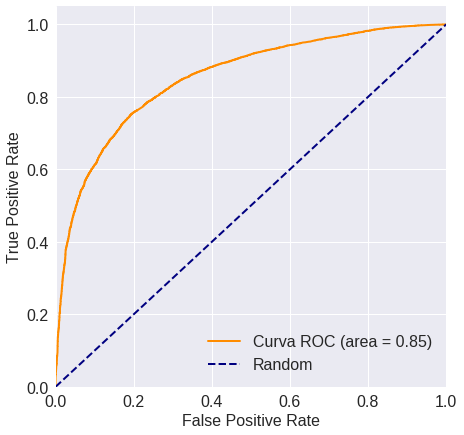

In [12]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/genomic/auc_rf.csv", index=False)

plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

plt.savefig("/home/marlan/Desktop/auc_genomic.pdf", bbox_inches='tight', pad_inches=0.1)